In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [25]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [26]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [27]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [28]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [29]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [30]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((478, 12, 1), (478,))

In [31]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [32]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [33]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 27s 430ms/step - loss: 0.1582 - root_mean_squared_error: 0.3978 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2078
Epoch 2/50
48/48 [==============================] - 20s 421ms/step - loss: 0.0905 - root_mean_squared_error: 0.3009 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2071
Epoch 3/50
48/48 [==============================] - 20s 423ms/step - loss: 0.0742 - root_mean_squared_error: 0.2725 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1975
Epoch 4/50
48/48 [==============================] - 19s 400ms/step - loss: 0.0651 - root_mean_squared_error: 0.2551 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 5/50
48/48 [==============================] - 19s 413ms/step - loss: 0.0489 - root_mean_squared_error: 0.2211 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 6/50
48/48 [==============================] - 22s 473ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0231 

48/48 [==============================] - 3s 57ms/step - loss: 0.0117 - root_mean_squared_error: 0.1084 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2285
Epoch 43/50
48/48 [==============================] - 3s 55ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2088
Epoch 44/50
48/48 [==============================] - 2s 44ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2480
Epoch 45/50
48/48 [==============================] - 3s 63ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2215
Epoch 46/50
48/48 [==============================] - 3s 66ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2042
Epoch 47/50
48/48 [==============================] - 2s 42ms/step - loss: 0.0117 - root_mean_squared_error: 0.1084 - val_loss: 0.0645 - val_root_mean_sq

In [34]:
time = (etime - stime)/60
print(f'{time} minutes')

4.331378455956777 minutes


In [35]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

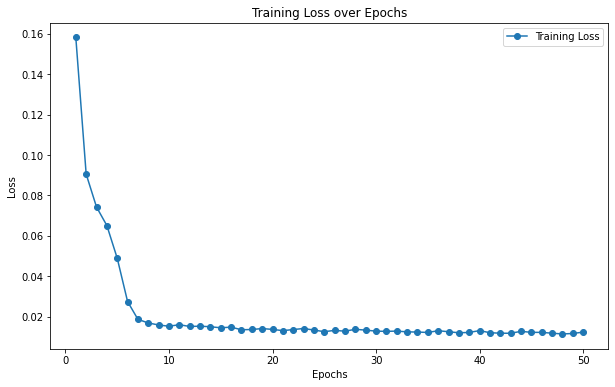

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

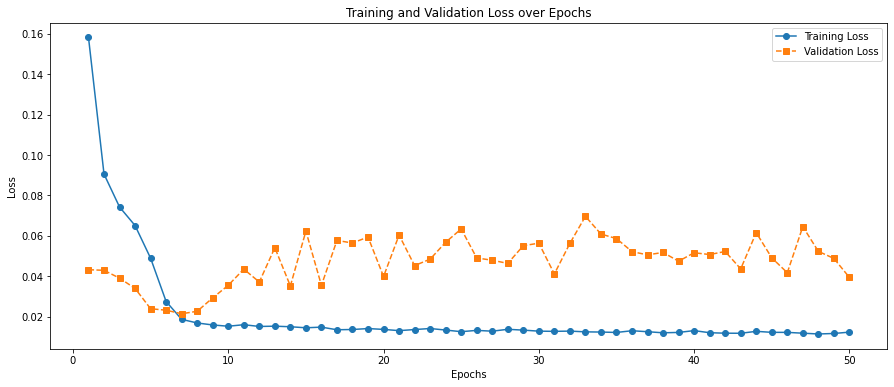

In [37]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [38]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT4/')

In [39]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 19ms/step


In [40]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09880674855637528
MAE : 0.0729571429876161


In [41]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [42]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,47595.570312,1707.377
1,107869.601562,11293.282
2,191999.671875,49957.406
3,295182.812500,151973.751
4,397152.156250,466524.938
5,486255.500000,708542.184
6,535779.000000,652598.000
7,492800.718750,414216.785
8,210855.687500,236263.303
9,-1792.882446,43422.368


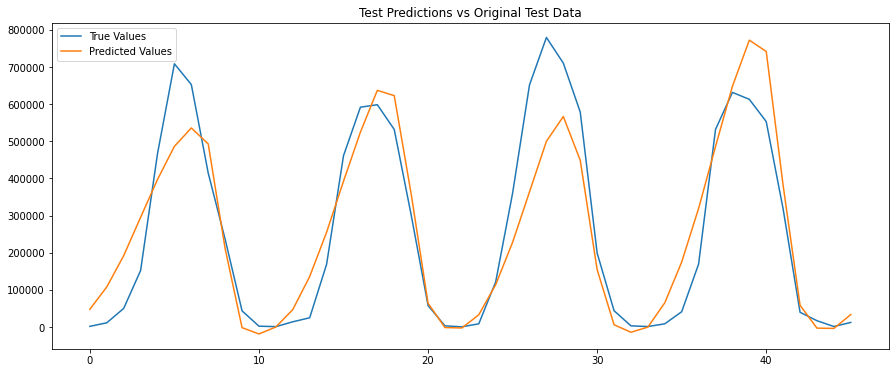

In [43]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [44]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 27ms/step


In [45]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

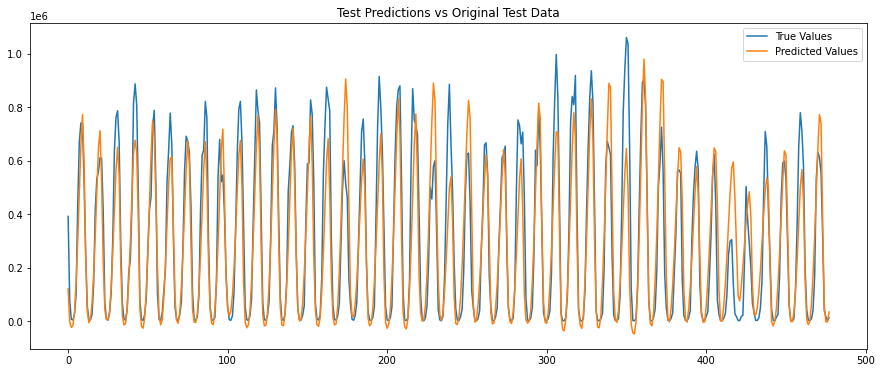

In [46]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()